In [1]:
import sys
sys.path.insert(1, '../src/magpies/')
from magpies import *
from atmos import *
import numpy as np
from math import *
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
## Radius and mass of neutron star
Rns = 12  ## km
Mns = 1.4 ## M_solar
Tb = pow(10, 7.1730)  ## K
Bp = 1e12 ## G

## Instrument and exposure
eph = np.linspace (0.20, 3.00, 32) ## Nicer soft X-ray range
nphot = 1e5

g14c = g14 (Rns, Mns) ## computing the free fall acceleration
 
print ('g14 = ', g14c)

g14 =  1.6054273795798544


In [3]:
## Initialising the atmosphere
atm_iron_2003 = NS_atmosphere ('Potekhin_2003_iron', g14c, Tb, Bp)
atm_iron_2003.describe ()

Surface temperatures for magnetised envelope of NS
Following fit from Potekhin, Yakovlev, Chabrier & Gnedin (2003) for iron envelope
The Astrophysical Journal, Volume 594, Issue 1, pp. 404-418  2003ApJ...594..404P
Same fits are provided in Beznogov, Potekhin & Yakovlev (2021) for iron envelope
Physics Reports, Volume 919, p. 1-68 2021PhR...919....1B


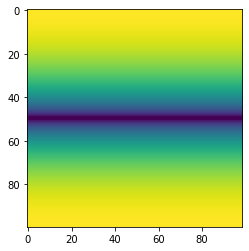

In [4]:
theta = np.linspace (0, pi, 100)  ## theta coordinates
phi   = np.linspace (0, 2*pi, 99) ## phi coordinates

theta1, phi1 = np.meshgrid (theta, phi)

Ts = atm_iron_2003.Ts (theta1) ## Surface temperatures

#for i in range (0, Ts.shape[0]):
#    for j in range (0, Ts.shape[1]):
#        Ts[i,j] = 1e6

plt.imshow(Ts.T)

In [5]:
## Here we produce and store the soft X-ray spectra for two orientations: pole on and equatorial 
sp_red_n, map_of_visible = get_redshifted_spectra_pole_photons (theta, phi, Ts, Rns, Mns, eph, nphot)
sp_red_n_eq, map_of_visible = get_redshifted_spectra_equator_photons (theta, phi, Ts, Rns, Mns, eph, nphot)

../src/magpies/magpies.py:186: RuntimeWarning: divide by zero encountered in log
  x = (1.0 - u)*y*(1.0 + u*u*y*y/112.0 - e/100.0*u*y*(np.log(1-y/2.0) + y/2))
../src/magpies/magpies.py:188: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(res)


In [6]:
L =  compute_L (theta, phi, Rns, Ts)
Teff = compute_Teff (theta, phi, Rns, Ts)
#bb1 = single_BB_photons (1.07*Teff, Rns, Mns, eph, nphot)
bb1 = examine_spectral_fit_1BB_photons ([0.6, 1.4], Teff, Rns, Mns, eph, nphot, L)
bb2 = examine_spectral_fit_2BB_photons ([0.4613, 0.2819, 1.0225, 1.1914], Teff, Rns, Mns, eph, nphot, L)
#bb2 = two_BB_photons ([0.4613, 0.2819, 1.0225, 1.1914], Teff, Rns, Mns, eph, nphot)

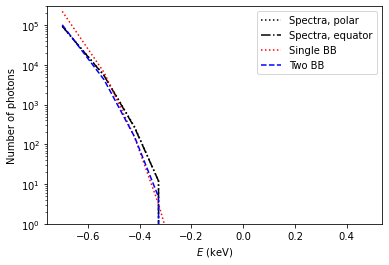

In [7]:
plt.plot (np.log10(eph), sp_red_n, 'k:', label='Spectra, polar')
plt.plot (np.log10(eph), sp_red_n_eq, 'k-.', label='Spectra, equator')
plt.plot (np.log10(eph), bb1, 'r:', label='Single BB')
plt.plot (np.log10(eph), bb2, 'b--', label='Two BB')
plt.xlabel(r'$E$ (keV)')
plt.ylabel('Number of photons')
plt.yscale('log')
plt.ylim([1, 3e5])
plt.legend()




[0.240951767837616, 0.240951767837616, 1.2002091691301269, 1.2002091691301269, 0.7067589591841177, 7.264183193367966]
1BB model param:  [0.481903535675232, 1.2002091691301269]
2BB model param:  [0.240951767837616, 0.240951767837616, 1.2002091691301269, 1.2002091691301269]
8.524564452236636e+30
8.524564452236636e+30


../src/magpies/magpies.py:311: RuntimeWarning: overflow encountered in exp
  res = 15.0*sigma_SB / ( pow(pi, 4) * pow(kB, 4)) * np.power(eph, 2) / (np.exp(eph / (kB *Teff_inf)) - 1.0) / (1.0 - xg)
../src/magpies/magpies.py:317: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = nphot / np.sum(res) #* Lcomp / L
../src/magpies/magpies.py:320: RuntimeWarning: invalid value encountered in multiply
  res_n = np.asarray(np.asarray(res) * coeff, dtype=int)


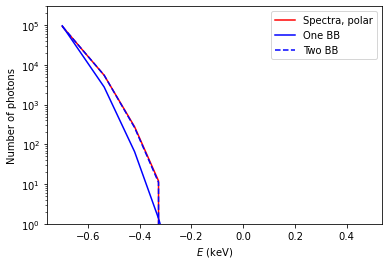

In [17]:
bb2_opt_par = fit_spectral_model_Cstat (Teff, Rns, Mns, sp_red_n, eph, nphot, L)
print (bb2_opt_par)

bb2_opt = examine_spectral_fit_2BB_photons (bb2_opt_par[0:4], Teff, Rns, Mns, eph, nphot, L)

bb1_opt = examine_spectral_fit_1BB_photons ([bb2_opt_par[0]*2, bb2_opt_par[2]], Teff, Rns, Mns, eph, nphot, L)

print ('1BB model param: ', [bb2_opt_par[0]*2, bb2_opt_par[2]])
print ('2BB model param: ', bb2_opt_par[0:4])


print (compute_L_param (bb2_opt_par[0:4], Teff, Rns, Mns))
print (compute_L_param ([bb2_opt_par[0]*2, bb2_opt_par[2]], Teff, Rns, Mns))


plt.plot (np.log10(eph), sp_red_n, 'r-', label='Spectra, polar')
plt.plot (np.log10(eph), bb1_opt, 'b-', label='One BB')
plt.plot (np.log10(eph), bb2_opt, 'b--', label='Two BB')
plt.xlabel(r'$E$ (keV)')
plt.ylabel('Number of photons')
plt.yscale('log')
plt.ylim([1, 3e5])
plt.legend()

In [13]:
print (chi2_1BB (1.2, Teff, Rns, Mns, sp_red_n, eph, nphot))

TypeError: chi2_1BB() missing 1 required positional argument: 'L'

In [ ]:
print (chi2_2BB (res[0:4], Teff, Rns, Mns, sp_red_n, eph, nphot))

In [ ]:
res_BB1 = single_BB_photons (res[2]*Teff, Rns, Mns, eph, nphot)

In [ ]:
res_BB2 = two_BB_photons ([res[0]*2, 0.001, res[2], 0.1], Teff, Rns, Mns, eph, nphot)

In [ ]:
plt.scatter (np.log10(eph), res_BB2, marker='*') #'r-')
plt.scatter (np.log10(eph), sp_red_n, marker='^') #'b--')
plt.yscale('log')
plt.ylim([1,1e6])

In [ ]:
print (np.min(res_BB1), np.min(res_BB2), np.min(sp_red_n))

In [ ]:
print (res_BB1[0:20])

In [ ]:
print (res_BB2[0:20])

In [ ]:
print (sp_red_n[0:20])

In [ ]:
print (np.sum(res_BB1), np.sum(res_BB2), np.sum(sp_red_n))

In [ ]:
print (Cstat_1BB (res[2], Teff, Rns, Mns, sp_red_n, eph, nphot))

In [ ]:
print (Cstat_2BB (res[0:4], Teff, Rns, Mns, sp_red_n, eph, nphot))

In [ ]:
print (fit_spectral_model_Cstat (Teff, Rns, Mns, sp_red_n, eph, nphot, L))